In [ ]:
from sf_quant.data.factors import load_factors, get_factor_names
import polars as pl
import datetime as dt
import numpy as np

import matplotlib.pyplot as plt

/home/boobus/projects/factor_momentum/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-29 12:24:08,417	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
start = dt.date(2000,1,1)
end = dt.date(2020,1,1)
factors = get_factor_names(type='style')

daily = load_factors(start=start, end=end, factors=factors)
daily = daily.unpivot(index='date', variable_name='factor', value_name='ret')
daily

date,factor,ret
date,str,f64
2000-01-03,"""USSLOWL_BETA""",0.208221
2000-01-04,"""USSLOWL_BETA""",-0.614978
2000-01-05,"""USSLOWL_BETA""",-0.235725
2000-01-06,"""USSLOWL_BETA""",-0.323232
2000-01-07,"""USSLOWL_BETA""",1.032833
…,…,…
2019-12-24,"""USSLOWL_VALUE""",-0.026242
2019-12-26,"""USSLOWL_VALUE""",0.078401
2019-12-27,"""USSLOWL_VALUE""",-0.057593


In [4]:
monthly = (daily.with_columns(
    pl.col('date').dt.truncate('1mo').alias('month')
)
.group_by(['factor', 'month']).agg(
    ((np.log(1 + pl.col('ret')*0.01).sum()
    .exp() - 1) * 100)
    .alias('ret')
)
.sort(['factor', 'month'])
.with_columns(
    pl.col('ret').shift(1).over('factor').alias('lag_ret')
)
)

monthly

factor,month,ret,lag_ret
str,date,f64,f64
"""USSLOWL_BETA""",2000-01-01,0.932998,null
"""USSLOWL_BETA""",2000-02-01,3.464071,0.932998
"""USSLOWL_BETA""",2000-03-01,-2.879828,3.464071
"""USSLOWL_BETA""",2000-04-01,-2.416919,-2.879828
"""USSLOWL_BETA""",2000-05-01,-1.474814,-2.416919
…,…,…,…
"""USSLOWL_VALUE""",2019-08-01,-0.753603,0.652968
"""USSLOWL_VALUE""",2019-09-01,0.677983,-0.753603
"""USSLOWL_VALUE""",2019-10-01,-0.049016,0.677983


In [5]:
monthly = (monthly.with_columns(
    pl.col("lag_ret").rank('dense').over('month').alias('rank'),
    pl.col('lag_ret').count().over('month').alias('count')
))
monthly

factor,month,ret,lag_ret,rank,count
str,date,f64,f64,u32,u32
"""USSLOWL_BETA""",2000-01-01,0.932998,null,null,0
"""USSLOWL_BETA""",2000-02-01,3.464071,0.932998,16,16
"""USSLOWL_BETA""",2000-03-01,-2.879828,3.464071,15,16
"""USSLOWL_BETA""",2000-04-01,-2.416919,-2.879828,3,16
"""USSLOWL_BETA""",2000-05-01,-1.474814,-2.416919,3,16
…,…,…,…,…,…
"""USSLOWL_VALUE""",2019-08-01,-0.753603,0.652968,13,16
"""USSLOWL_VALUE""",2019-09-01,0.677983,-0.753603,4,16
"""USSLOWL_VALUE""",2019-10-01,-0.049016,0.677983,14,16


In [6]:
monthly = (monthly.with_columns(
    pl.when(pl.col('rank') >= pl.col('count')/2)
    .then(1)
    .otherwise(-1)
    .alias('signal')
))
monthly

factor,month,ret,lag_ret,rank,count,signal
str,date,f64,f64,u32,u32,i32
"""USSLOWL_BETA""",2000-01-01,0.932998,null,null,0,-1
"""USSLOWL_BETA""",2000-02-01,3.464071,0.932998,16,16,1
"""USSLOWL_BETA""",2000-03-01,-2.879828,3.464071,15,16,1
"""USSLOWL_BETA""",2000-04-01,-2.416919,-2.879828,3,16,-1
"""USSLOWL_BETA""",2000-05-01,-1.474814,-2.416919,3,16,-1
…,…,…,…,…,…,…
"""USSLOWL_VALUE""",2019-08-01,-0.753603,0.652968,13,16,1
"""USSLOWL_VALUE""",2019-09-01,0.677983,-0.753603,4,16,-1
"""USSLOWL_VALUE""",2019-10-01,-0.049016,0.677983,14,16,1


In [7]:
port = (monthly.group_by(['month', 'signal'])
        .agg(pl.col('ret').mean().alias('mean_ret'))
        .sort(['signal', 'month'])
        .pivot(on='signal', index='month', values='mean_ret')
        .drop_nulls()
        )
port

month,-1,1
date,f64,f64
2000-02-01,-1.370545,1.106019
2000-03-01,0.798595,-1.351971
2000-04-01,-1.507531,1.06995
2000-05-01,-0.768455,0.968476
2000-06-01,1.977217,-0.71256
…,…,…
2019-08-01,-0.635472,0.09569
2019-09-01,0.120155,-0.353478
2019-10-01,0.221408,-0.118813


[]

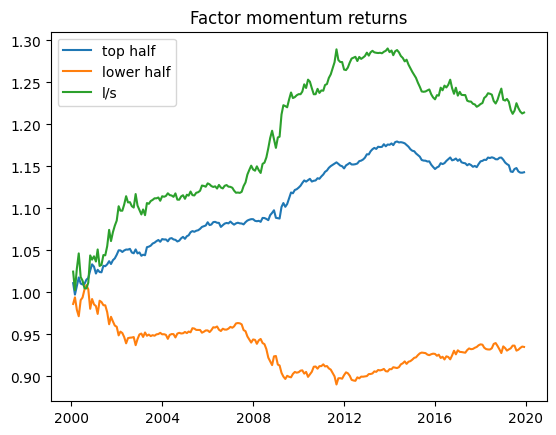

In [8]:
x = port['month']
y_1 = (1+port['1']*0.01).cum_prod()
y_2 = (1+port['-1']*0.01).cum_prod()
y_3 = (1+(port['1']-port['-1'])*0.01).cum_prod()

plt.title('Factor momentum returns')
plt.plot(x, y_1, label='top half')
plt.plot(x, y_2, label='lower half')
plt.plot(x, y_3, label='l/s')
plt.legend()
plt.plot()